# Qualitative Experiments with LXDR
In this notebook, we are presenting an example on how we can use LXDR in two actual scenarios. 

In [1]:
import numpy as np
import site, pprint, math, re, numpy
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA, NMF, LatentDirichletAllocation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity as cd, euclidean_distances as ed
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import shuffle
from sklearn import datasets
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from lxdr import LXDR

In [2]:
def my_clean(text, stemming=False):
    text = str(text)
    text = re.sub(r" US ", " american ", text)
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"don't", "do not ", text)
    text = re.sub(r"aren't", "are not ", text)
    text = re.sub(r"isn't", "is not ", text)
    text = re.sub(r"%", " percent ", text)
    text = re.sub(r"that's", "that is ", text)
    text = re.sub(r"doesn't", "does not ", text)
    text = re.sub(r"he's", "he is ", text)
    text = re.sub(r"she's", "she is ", text)
    text = re.sub(r"it's", "it is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.lower().split()
    text = [w for w in text if len(w) >= 2]
    if stemming:
        wordnet_lemmatizer = WordNetLemmatizer()
        englishStemmer = SnowballStemmer("english", ignore_stopwords=True)
        text = [englishStemmer.stem(word) for word in text]
        text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [3]:
def plot_top_words(components_, feature_names, n_top_words, title, allowed = None):

    if allowed is not None:
        fig, axes = plt.subplots(1, 5, figsize=(24, 4), dpi=300)
        axes = axes.flatten()
        xx = 0
        for topic_idx in allowed:
            topic = components_[topic_idx]
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[xx]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 25})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=20)
            for i in "top right left".split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=20)
            xx = xx + 1
    else:
        fig, axes = plt.subplots(4, 5, figsize=(32, 15), dpi=200)
        axes = axes.flatten()
        for topic_idx, topic in enumerate(components_):#opou o model.components

            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=20)
            for i in "top right left".split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.35)
    plt.show()

In [4]:
n_features = 10000
n_top_words = 10
batch_size = 128

loading dataset:

In [5]:
data_samples, y = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)

In [6]:
classes = fetch_20newsgroups()['target_names']

In [7]:
x_train, x_test, y_train, y_test = train_test_split([my_clean(d,True) for d in data_samples], y, test_size=0.2, random_state=42) 

In [8]:
x_train_clean, x_test_clean, y_train, y_test = train_test_split(data_samples, y, test_size=0.2, random_state=42) 

In [9]:
x_test_clean[42]

"This is turning into 'what's a moonbase good for', and I ought\nnot to post when I've a hundred some odd posts to go, but I would\nthink that the real reason to have a moon base is economic.\n\nSince someone with space industry will presumeably have a much\nlarger GNP than they would _without_ space industry, eventually,\nthey will simply be able to afford more stuff."

In [10]:
x_test_clean[26]

'\n(regarding NSA monitoring of US military code traffic)\n\n\nOn the contrary- The Walker spy case is one where the KGB was\ngiven keys (as I recall)\n-- \n'

In [11]:
del y, data_samples

We will use the simple TFIDF Vectorizer to transformm our text to vectors

In [12]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=n_features, stop_words="english")
tfidf_vectorizer.fit(x_train)
train = tfidf_vectorizer.transform(x_train)
test = tfidf_vectorizer.transform(x_test)

In [13]:
del x_train

In [14]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

We train both LDA and KPCA for our model

In [ ]:
for n_components in [100]: #500, 100, 50, 20
    
    lda = LatentDirichletAllocation(
    n_components=n_components,
    random_state=1).fit(train)
    
    kpca = KernelPCA(
    n_components=n_components,
    random_state=1,
    kernel='rbf').fit(train)
    
    train_l = lda.transform(train)
    test_l = lda.transform(test)
    
    train_k = kpca.transform(train)
    test_k = kpca.transform(test)
    
    scaler1 = MinMaxScaler().fit(train_k)
    scaler = MinMaxScaler().fit(train_l)
    train_k_s = scaler1.transform(train_k)
    train_l_s = scaler.transform(train_l)
    clf_k = OneVsRestClassifier(LogisticRegression(C=100)).fit(train_k_s, y_train)
    clf_l = OneVsRestClassifier(LogisticRegression(C=100)).fit(train_l_s, y_train)
    
    test_k_s = scaler1.transform(test_k)
    test_l_s = scaler.transform(test_l)
    print(n_components)
    print('Accuracy Performance KPCA:', accuracy_score(y_test,clf_k.predict(test_k_s)))
    print('Accuracy Performance LDA:', accuracy_score(y_test,clf_l.predict(test_l_s)))
    print('F1 Performance KPCA:', f1_score(y_test,clf_k.predict(test_k_s),average='macro'))
    print('F1 Performance LDA:', f1_score(y_test,clf_l.predict(test_l_s),average='macro'))

In [16]:
n_components = 100
n_tops_words = 8

And we train a logistic regression model to perform multiclass classification

In [ ]:
clf = OneVsRestClassifier(LogisticRegression(C=100)).fit(train, y_train)
print('Accuracy Performance with no reduction:', accuracy_score(y_test,clf.predict(test)))
print('F1 Performance with no reduction:', f1_score(y_test,clf.predict(test),average='macro'))

## LDA Weights

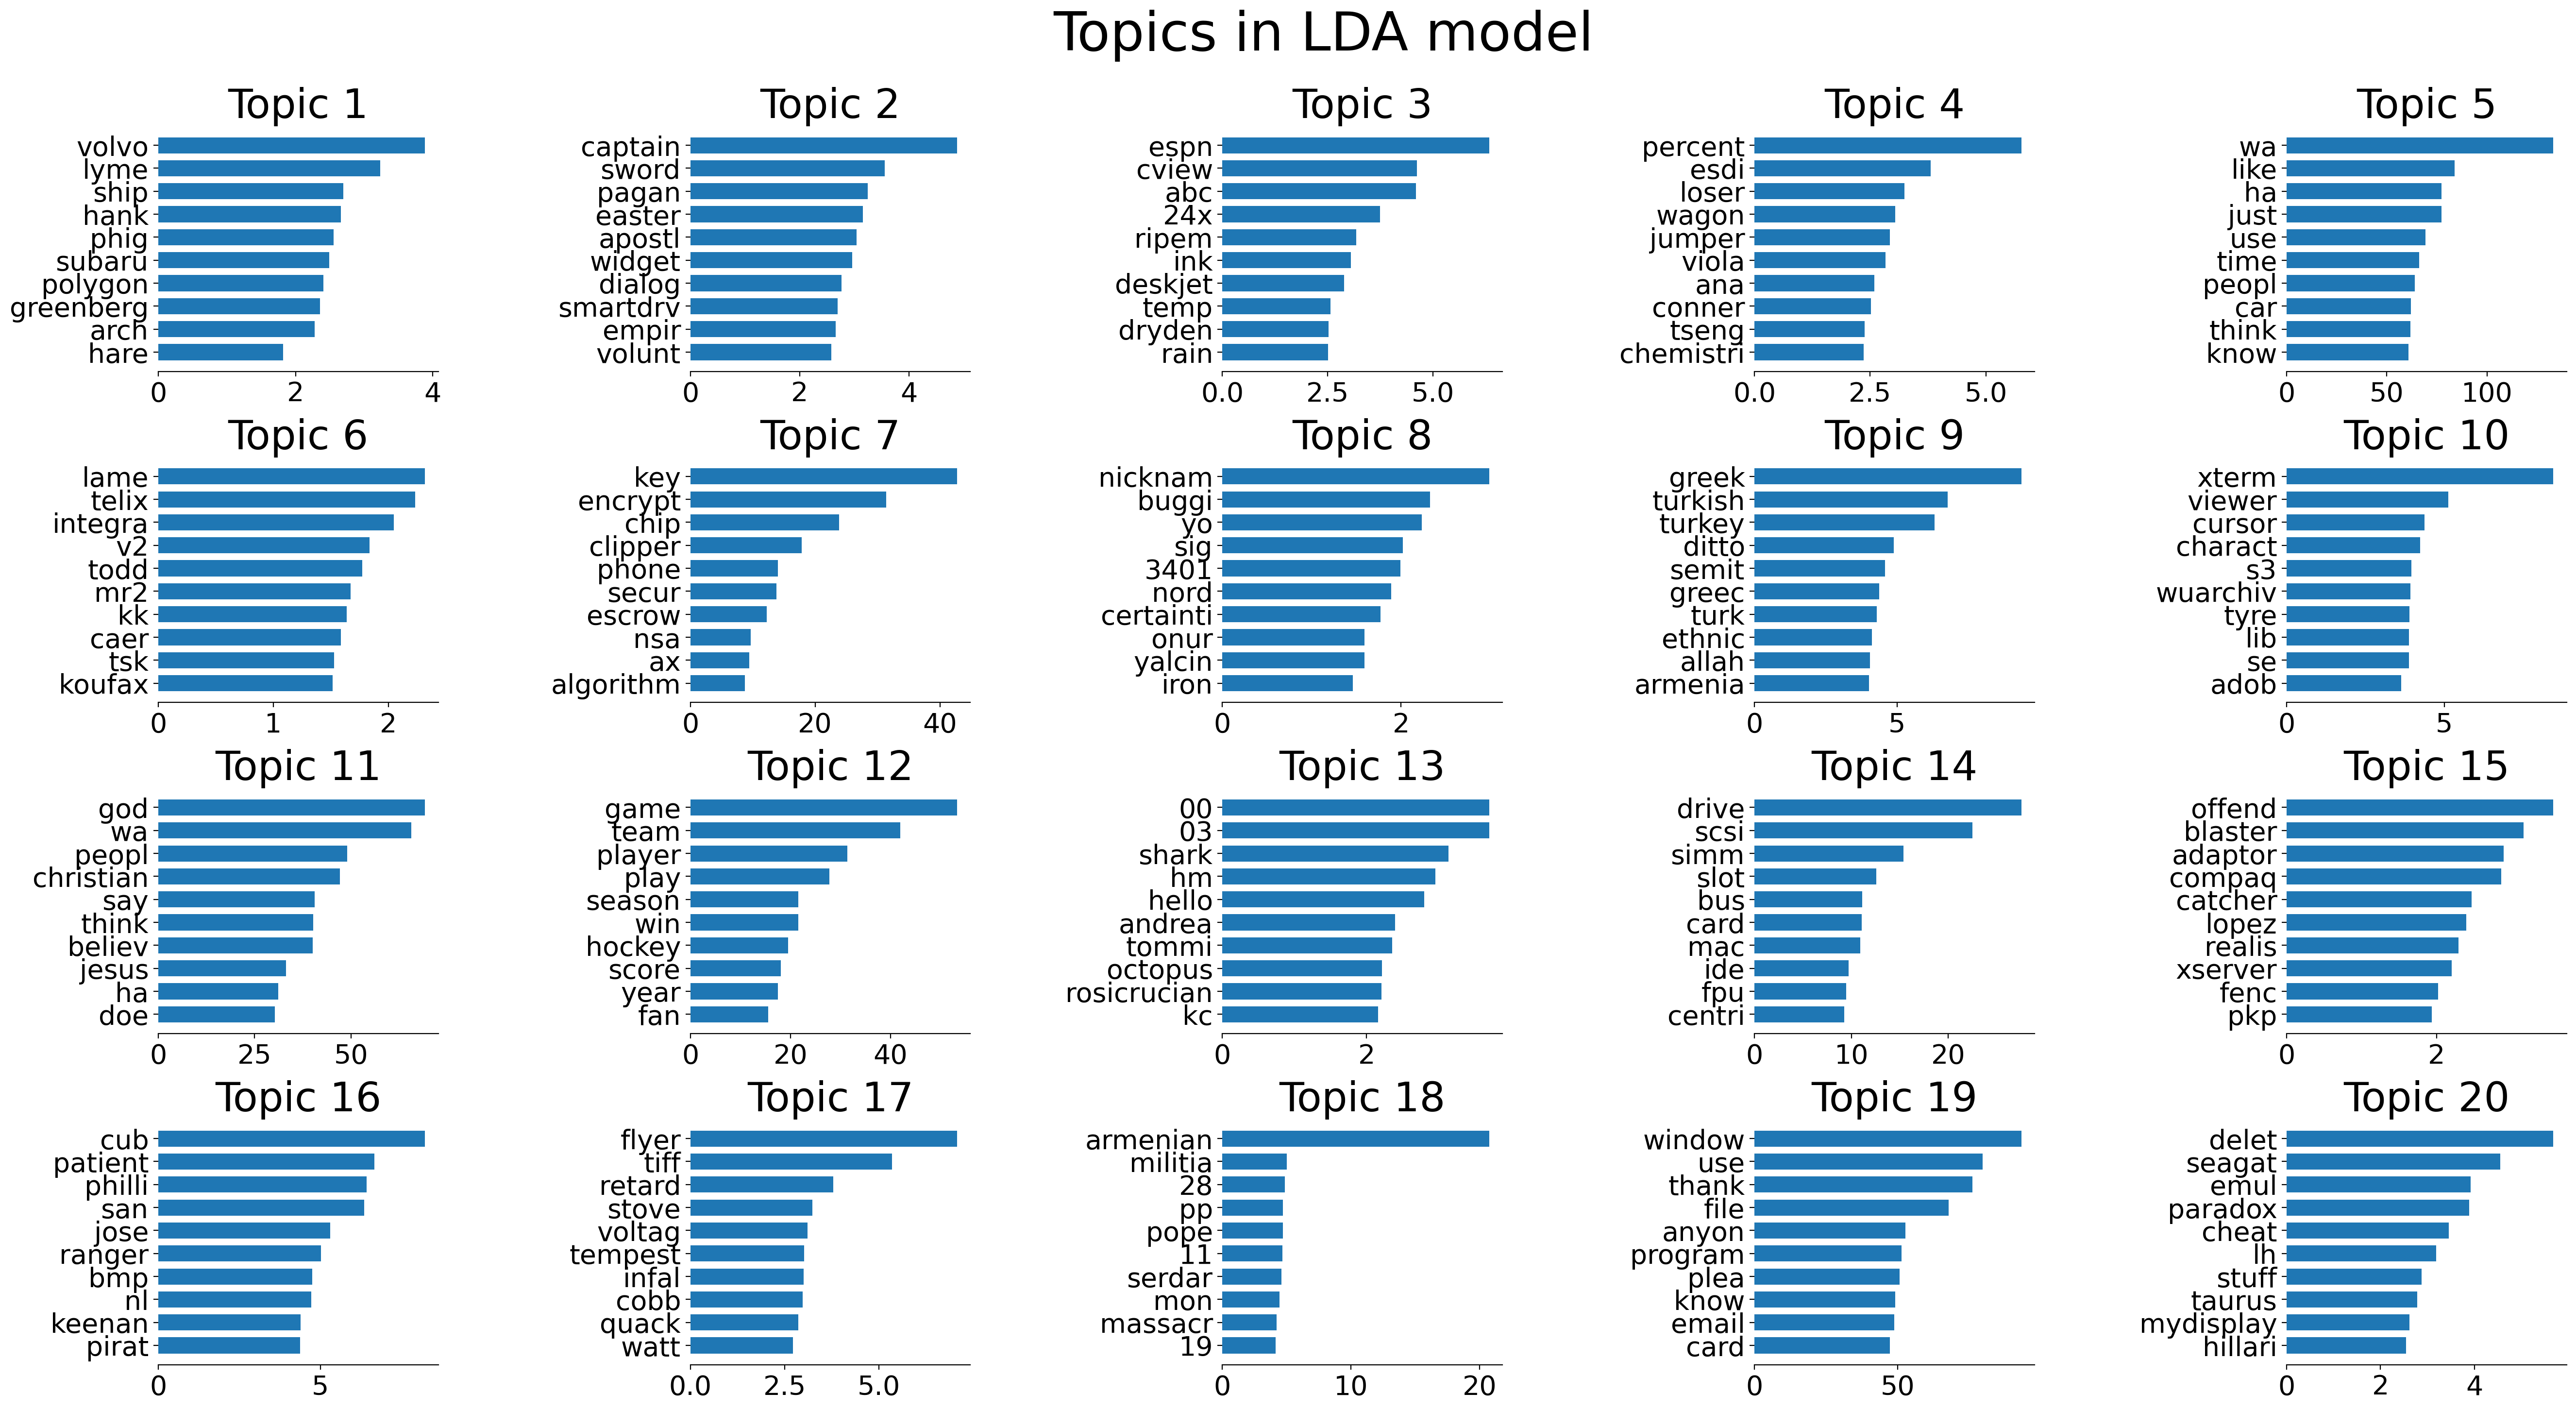

In [20]:
plot_top_words(
    lda.components_,
    tfidf_feature_names,
    n_top_words,
    "Topics in LDA model",
)

# Qualitative

In [18]:
ours = LXDR(kpca, tfidf_feature_names, train.A, False, ltype = 'locallocal')
ours._set_knn_local()

In [19]:
del kpca

In [20]:
dataid = 42
print('Instance: ',x_test[dataid])
print()
#print('Reduced Representation: ', [round(i,4) for i in list(test_k_s[dataid])])
print('Ground truth: ', y_test[dataid], classes[y_test[dataid]])
print('Prediction via KPCA: ',clf_k.predict(test_k_s)[dataid], classes[clf_k.predict(test_k_s)[dataid]])
print('Prediction via LDA: ',clf_l.predict(test_l_s)[dataid], classes[clf_l.predict(test_l_s)[dataid]])
#print('Most influencing topics of KPCA: ',clf_k.coef_[14]*test_k_s[dataid])
print('Most influencing topics of LDA: ',np.argmax(clf_l.coef_[14]*test_l_s[dataid])+1)
print('Most influencing topics of KPCA G: ',np.argmax(clf_k.coef_[14])+1)
print('Most influencing topics of LDA G: ',np.argmax(clf_l.coef_[14])+1)

Instance:  this is turn into what is moonbas good for and ought not to post when have hundr some odd post to go but would think that the real reason to have moon base is econom sinc someon with space industri will presum have much larger gnp than they would without space industri eventu they will simpli be abl to afford more stuff

Ground truth:  14 sci.space
Prediction via KPCA:  14 sci.space
Prediction via LDA:  15 soc.religion.christian
Most influencing topics of LDA:  11
Most influencing topics of KPCA G:  15
Most influencing topics of LDA G:  90


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


In [235]:
a = [[(clf_k.coef_[14]*test_k_s[dataid])[i],i] for i in range(100)]
a.sort(key = lambda x: x[0])
a[-5:]

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


[[2.422018288824, 30],
 [4.453604322736406, 26],
 [4.471809514402113, 0],
 [5.1386038890688885, 14],
 [7.545883497188279, 24]]

In [237]:
a = [[(clf_l.coef_[14]*test_l_s[dataid])[i],i] for i in range(100)]
a.sort(key = lambda x: x[0])
a[-5:]

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


[[0.011103340988980675, 50],
 [0.02710536552998465, 89],
 [0.3473860930341656, 13],
 [0.41359178192127055, 49],
 [0.8316031423101882, 10]]

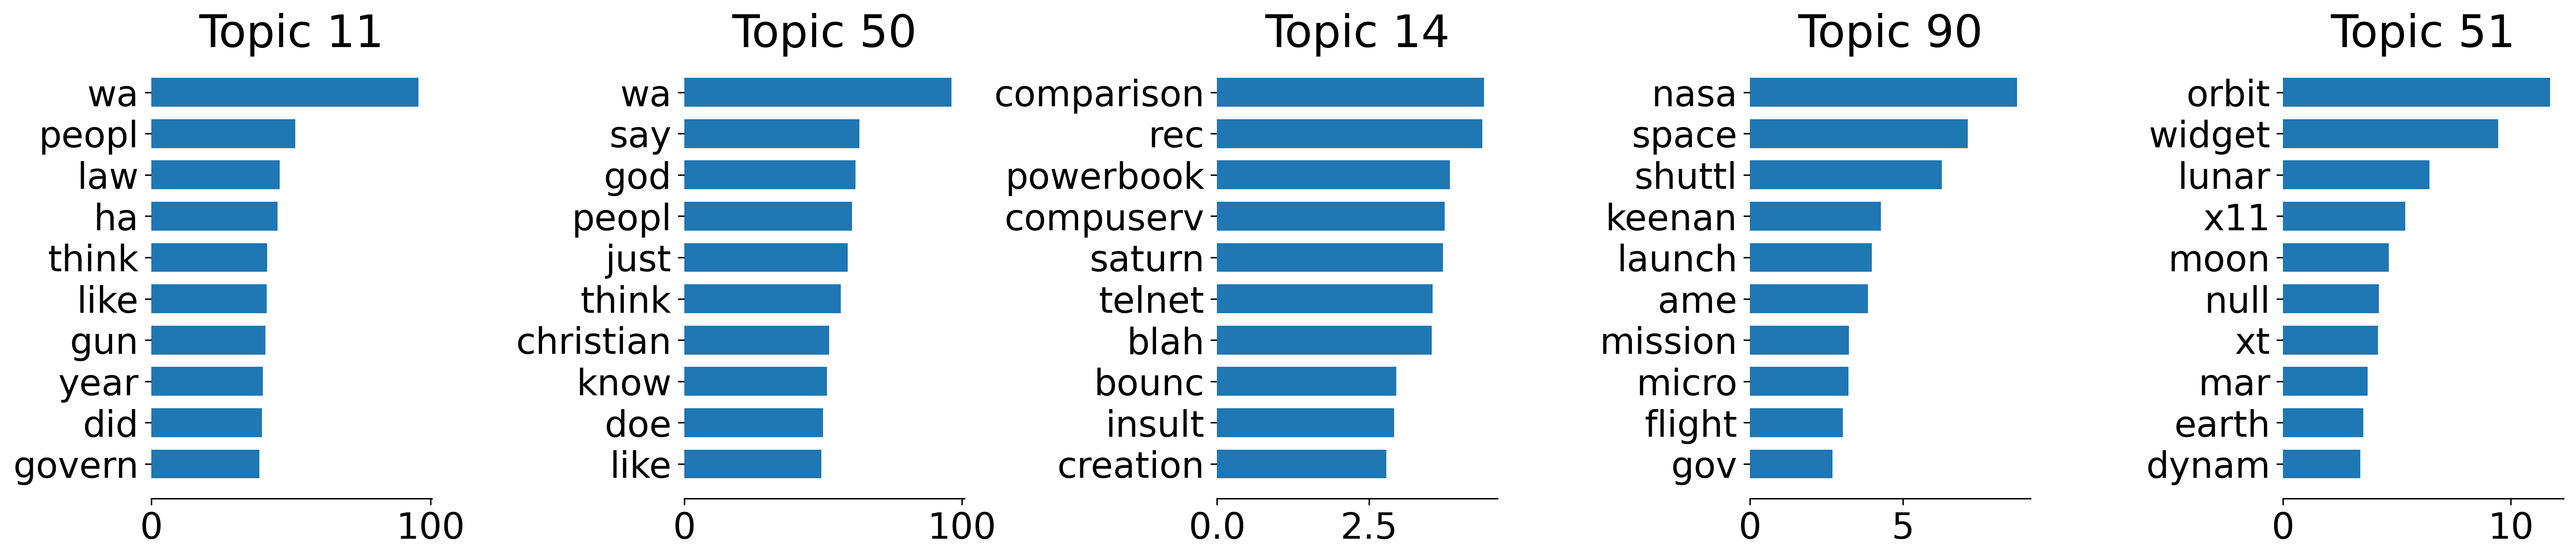

In [238]:
plot_top_words(
    lda.components_,
    tfidf_feature_names,
    n_top_words,
    "",
    [10, 49, 13, 89, 50]
)

In [22]:
ts = time()
components_ = ours.explain_instance(test.A[dataid], number_of_neighbours=300, auto_alpha=True, ng_technique= 'KNN')
time()-ts

58.91545009613037

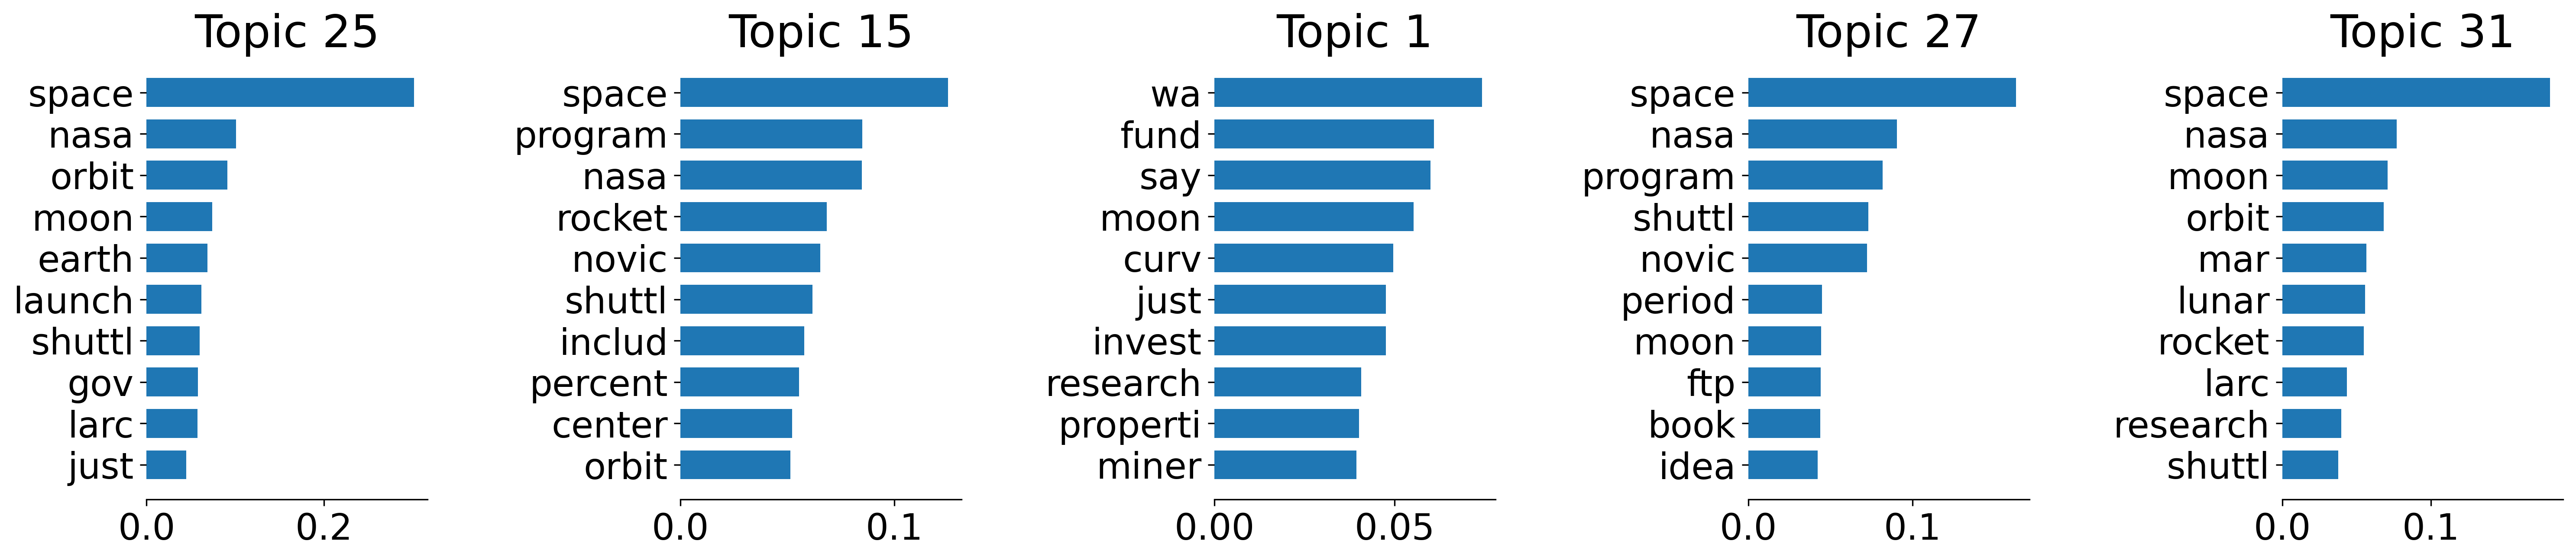

In [243]:
plot_top_words(
    components_*100,
    tfidf_feature_names,
    n_top_words,
    "",
    [24, 14, 0, 26, 30]#300
)

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


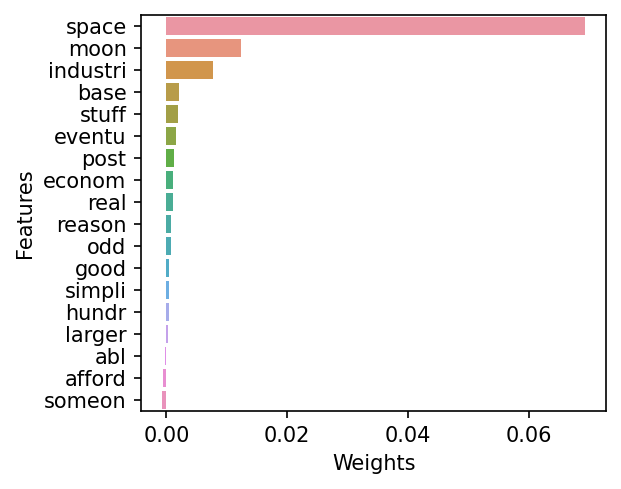

In [277]:
aa = clf_k.coef_[14]#*test_k_s[dataid]
bb = scaler1.inverse_transform([aa])[0]
#cc = ours.explain_instance(test.A[dataid], number_of_neighbours=300,
#                         auto_alpha=True, ng_technique= 'KNN')
local = np.dot(bb,components_)# + mean
local = local.tolist()*test.A[dataid]*100

model_weights = pd.DataFrame({"Features": tfidf_feature_names, "Weights": list(local)}) #If you want to display global structure remove the * INSTANCE
model_weights = model_weights.sort_values(by="Weights", ascending=False)
model_weights = model_weights[(abs(model_weights["Weights"]) > 0.0002)]
#Moreover if there are many features you can take head 10 and tail 10 of the dataframe and display only 20 features
plt.figure(num=None, figsize=(4, 3.5), dpi=150, facecolor='w', edgecolor='k')
sns.barplot(x="Weights", y="Features", data=model_weights)
plt.xticks(rotation=0)
plt.show()

In [278]:
dataid = 26
print('Instance: ',x_test[dataid])
print()
#print('Reduced Representation: ', [round(i,4) for i in list(test_k_s[dataid])])
print('Ground truth: ', y_test[dataid], classes[y_test[dataid]])
print('Prediction via KPCA: ',clf_k.predict(test_k_s)[dataid], classes[clf_k.predict(test_k_s)[dataid]])
print('Prediction via LDA: ',clf_l.predict(test_l_s)[dataid], classes[clf_l.predict(test_l_s)[dataid]])
#print('Most influencing topics of KPCA: ',clf_k.coef_[4]*test_k_s[dataid])
print('Most influencing topics of LDA: ',np.argmax(clf_l.coef_[12]*test_l_s[dataid])+1)
print('Most influencing topics of KPCA G: ',np.argmax(clf_k.coef_[12])+1)
print('Most influencing topics of LDA G: ',np.argmax(clf_l.coef_[12])+1)

Instance:  regard nsa monitor of american militari code traffic on the contrari the walker spi case is one where the kgb wa given key a recal

Ground truth:  11 sci.crypt
Prediction via KPCA:  11 sci.crypt
Prediction via LDA:  11 sci.crypt
Most influencing topics of LDA:  94
Most influencing topics of KPCA G:  10
Most influencing topics of LDA G:  71


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


In [228]:
a = [[(clf_k.coef_[11]*test_k_s[dataid])[i],i] for i in range(100)]
a.sort(key = lambda x: x[0])
a[-5:]

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


[[1.709403680405219, 61],
 [2.501755109127337, 79],
 [3.9162646833602417, 11],
 [4.25825521470841, 8],
 [17.954338008456414, 2]]

In [229]:
a = [[(clf_l.coef_[11]*test_l_s[dataid])[i],i] for i in range(100)]
a.sort(key = lambda x: x[0])
a[-5:]

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


[[0.12707777234474688, 19],
 [0.45540257296649006, 17],
 [0.716854345490602, 49],
 [0.8525218391229011, 93],
 [1.7875202956680798, 72]]

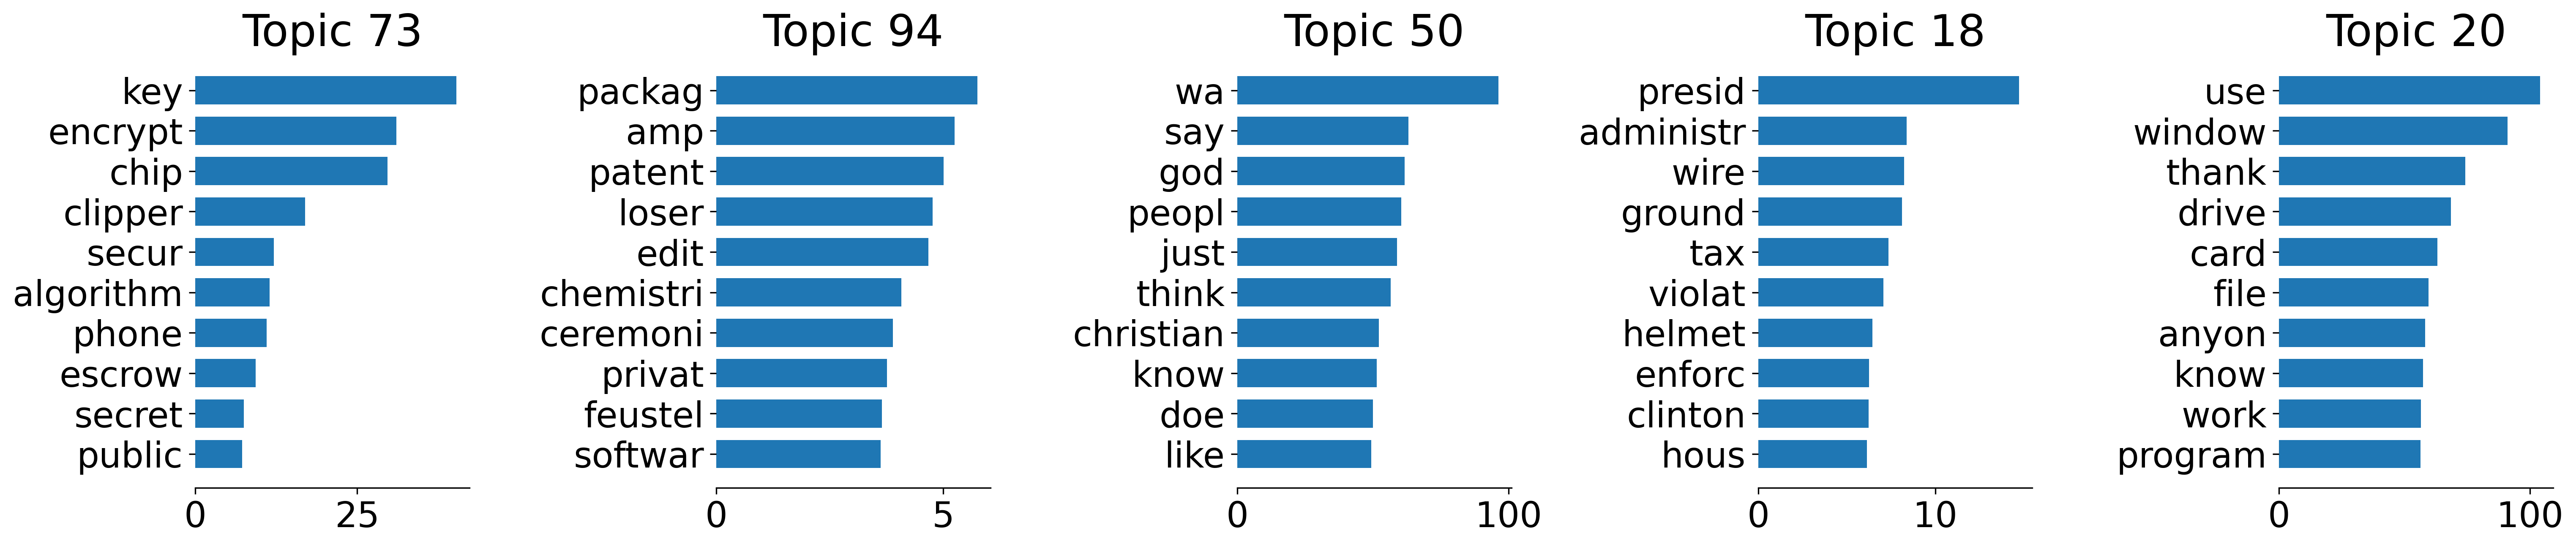

In [230]:
plot_top_words(
    lda.components_,
    tfidf_feature_names,
    n_top_words,
    "",
    [72, 93, 49, 17, 19]
)

In [279]:
components_ = ours.explain_instance(test.A[dataid], number_of_neighbours=300,
                         auto_alpha=True, ng_technique= 'KNN')

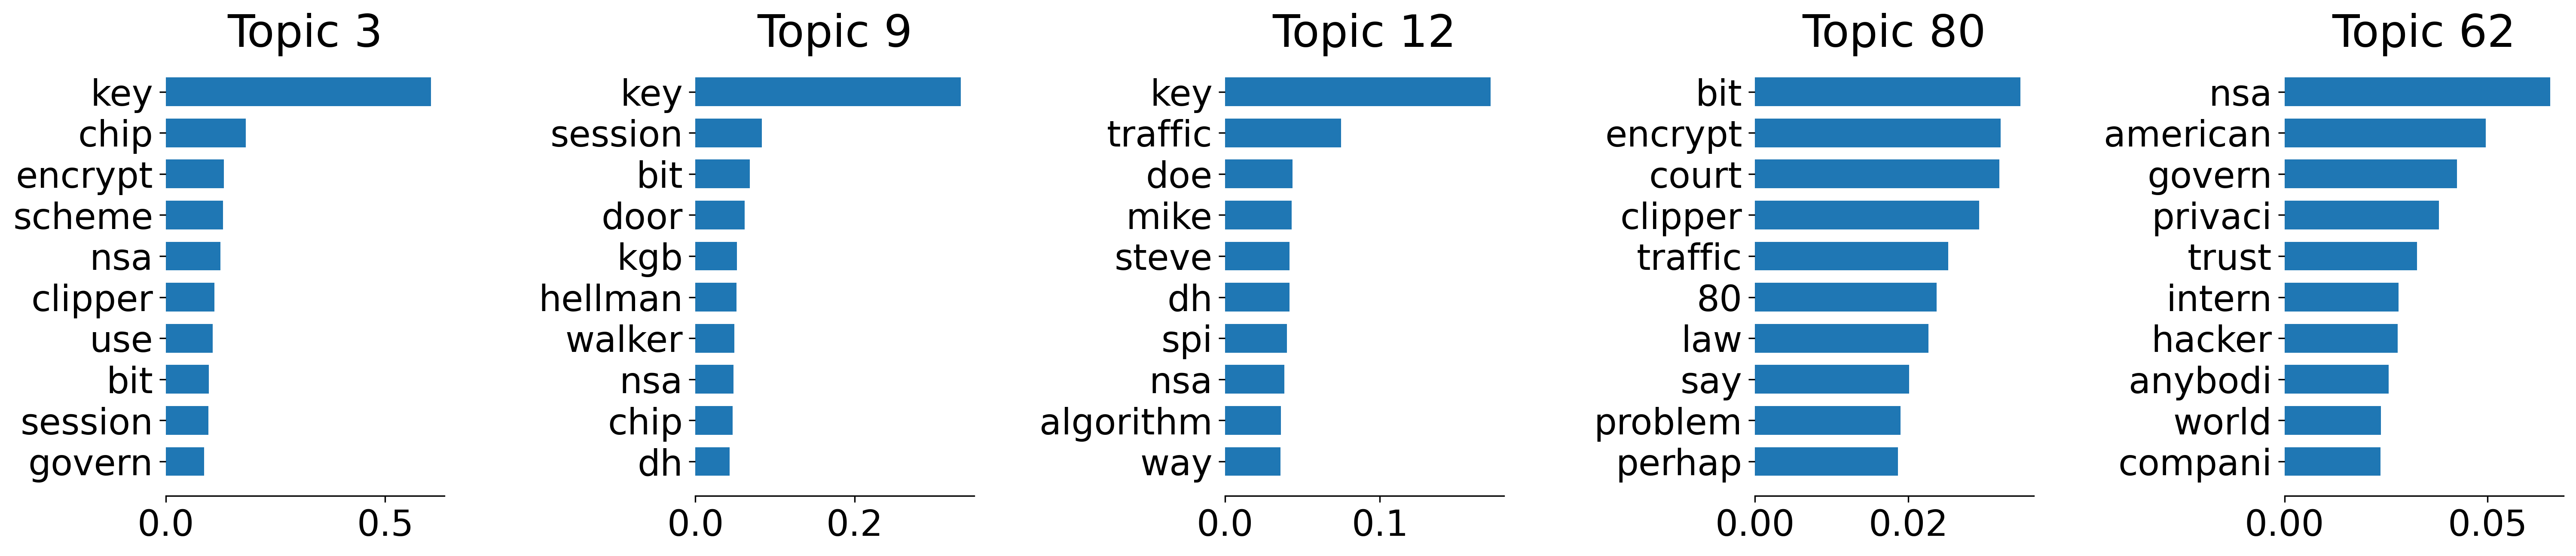

In [246]:
plot_top_words(
    components_*100,
    tfidf_feature_names,
    n_top_words,
    "",
    [2, 8, 11, 79, 61]#300
)

We ask for the ML model's interpretation! The global weights are the following:

In [280]:
aa = clf_k.coef_[11]#*test_k_s[dataid]
bb = scaler1.inverse_transform([aa])[0]
#cc = ours.explain_instance(test.A[dataid], number_of_neighbours=300,
#                         auto_alpha=True, ng_technique= 'KNN')
local = np.dot(bb,components_)# + mean
local = local.tolist()*test.A[dataid]*100

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


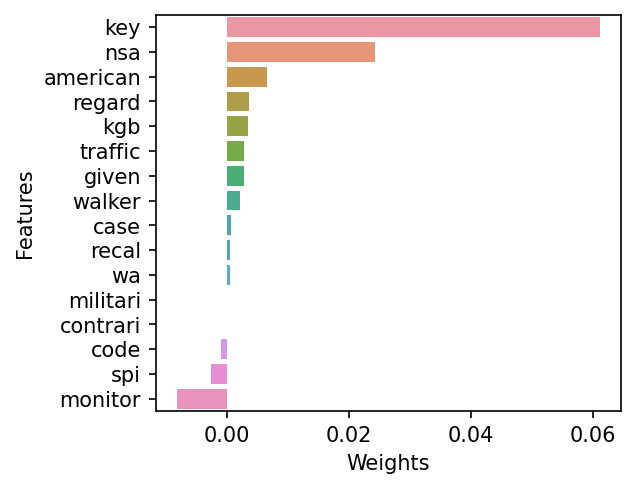

In [281]:
aa = clf_k.coef_[11]#*test_k_s[dataid]
bb = scaler1.inverse_transform([aa])[0]
#cc = ours.explain_instance(test.A[dataid], number_of_neighbours=300,
#                         auto_alpha=True, ng_technique= 'KNN')
local = np.dot(bb,components_)# + mean
local = local.tolist()*test.A[dataid]*100

model_weights = pd.DataFrame({"Features": tfidf_feature_names, "Weights": list(local)})
model_weights = model_weights.sort_values(by="Weights", ascending=False)
model_weights = model_weights[(model_weights["Weights"] != 0)]
#Moreover if there are many features you can take head 10 and tail 10 of the dataframe and display only 20 features
plt.figure(num=None, figsize=(4, 3.5), dpi=150, facecolor='w', edgecolor='k')
sns.barplot(x="Weights", y="Features", data=model_weights)
plt.xticks(rotation=0)
plt.show()